# <div style="background-color: #76B1ED; color: white; padding: 20px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 35px; margin: 5px; font-weight:bold;">Pneumonia Detection</div>


<center>
<img src="https://user-images.githubusercontent.com/76659596/107152793-30234600-696a-11eb-8827-56cb0c3a7578.png" alt="Student" width="auto" height="auto" style="border-radius:25px">
</center>

---

## What is Pneumonia?

Pneumonia is an **infection that affects one or both lungs**, causing the **air sacs (alveoli)** to fill up with **fluid or pus**.

It can be caused by:
- 🦠 **Bacteria**
- 🧬 **Viruses**
- 🍄 **Fungi**

### 💡 Common Symptoms:
- Cough *(with or without mucus)*
- Fever and chills
- Difficulty breathing

> **The severity of pneumonia** depends on:
> - Your **age**
> - Your **overall health**
> - The **type of infection** causing it

---


# 📌 Notebook Description

This notebook presents a deep learning approach for pneumonia classification using chest X-ray images. We explore both a custom CNN model and powerful transfer learning techniques via MobileNetV2 and DenseNet121.

The dataset is preprocessed, balanced, and augmented for optimal performance. Models are trained, evaluated, and compared using metrics like accuracy, confusion matrix, and classification report.

Finally, a holdout test set is used to assess the generalization capability of each model, with sample predictions visualized to ensure interpretability.


# 📚 Project Overview

This notebook presents a full end-to-end deep learning pipeline for **image classification**, structured into five main phases. Each phase is carefully designed to ensure reproducibility, scalability, and clarity:

---

### 🧱 **Phase 1: Data Collection & Organization**
- Explore the original dataset structure.
- Merge and flatten images into unified folders.
- Generate metadata CSVs for train/test splits.

---

### 🔎 **Phase 2: Data Preprocessing**
- Load and explore metadata.
- Balance classes in the training set.
- **Data Augmentation & Image Generators** using `ImageDataGenerator` with real-time transformations.
- Visualize augmented samples for verification.

---

### 🧠 **Phase 3: Modeling**
- 📌 **Model 1:** Custom CNN
- 📌 **Model 2:** MobileNetV2 *(Transfer Learning)*
- 📌 **Model 3:** DenseNet121 *(Transfer Learning)*

Each model is trained and validated using the same data pipeline for fair comparison.

---

### 🧪 **Phase 4: Evaluation, Comparison & Model Saving**
- Evaluate each model on validation data.
- Visualize confusion matrices and classification reports.
- Compare model performance side-by-side.
- Save trained models and the **Class Label Encoder**.
- **Build a Predict Function for Inference**.

---

### 📊 **Phase 5: Final Generalization Testing on Holdout Set**
- Load and preprocess the test set using the same pipeline.
- Evaluate all saved models on unseen test data.
- Generate confusion matrices and classification reports.
- Visualize sample predictions with predicted vs actual labels.

---


# 🧱 Phase 1: Data Collection & Organization

## 1. Explore Original Dataset Structure

Dataset Summary:
train - PNEUMONIA: 3875 images
train - NORMAL: 1341 images
val - PNEUMONIA: 8 images
val - NORMAL: 8 images
test - PNEUMONIA: 390 images
test - NORMAL: 234 images


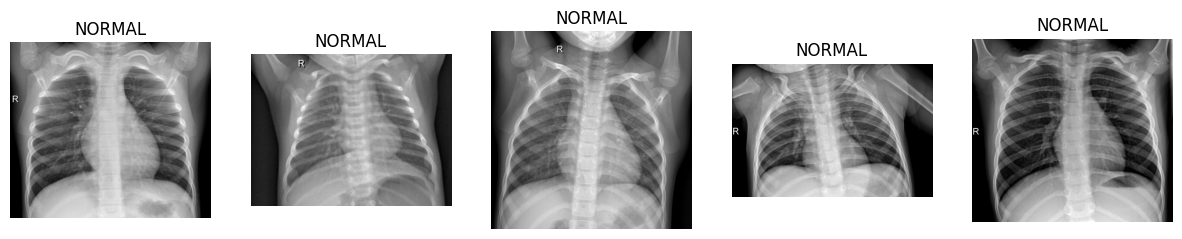

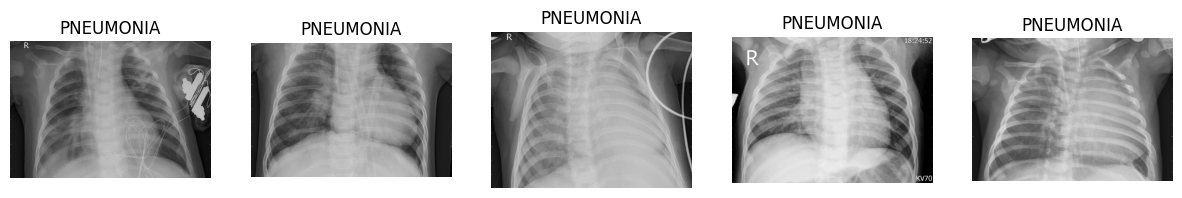

In [1]:
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from PIL import Image

# Define dataset paths
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Function to count images in each class folder
def count_images(folder):
    classes = os.listdir(folder)
    for cls in classes:
        class_path = os.path.join(folder, cls)
        num_images = len(os.listdir(class_path))
        print(f"{folder.split('/')[-1]} - {cls}: {num_images} images")

# Print dataset structure summary
print("Dataset Summary:")
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

# Function to display sample images from a class
def show_sample_images(folder, label, num_images=5):
    image_paths = os.listdir(os.path.join(folder, label))
    sample_paths = random.sample(image_paths, num_images)
    
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(sample_paths):
        img_path = os.path.join(folder, label, image_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(label)
        plt.axis("off")
    plt.show()

# Show example images from each class in training set
show_sample_images(train_dir, "NORMAL")
show_sample_images(train_dir, "PNEUMONIA")


## 2. Merge & Flatten Dataset into Unified Folders

In [2]:
import os
import shutil

# Define output directory
output_base = "/kaggle/working/processed_data"
os.makedirs(output_base, exist_ok=True)

# Create unified folders
unified_train_dir = os.path.join(output_base, "train")
os.makedirs(unified_train_dir, exist_ok=True)

test_output_dir = os.path.join(output_base, "test")
os.makedirs(test_output_dir, exist_ok=True)

labels = ['NORMAL', 'PNEUMONIA']
metadata = {
    'train': [],
    'test': []
}

# Merge train and val into a single train folder
for split in ['train', 'val']:
    for label in labels:
        source_path = os.path.join(base_dir, split, label)
        image_names = os.listdir(source_path)

        for image_name in image_names:
            src = os.path.join(source_path, image_name)
            new_filename = f"{label.lower()}_{split}_{image_name}"
            dst = os.path.join(unified_train_dir, new_filename)
            shutil.copy(src, dst)
            metadata['train'].append({'filename': new_filename, 'label': label})

# Copy test images to test folder
for label in labels:
    source_path = os.path.join(base_dir, "test", label)
    image_names = os.listdir(source_path)

    for image_name in image_names:
        src = os.path.join(source_path, image_name)
        new_filename = f"{label.lower()}_test_{image_name}"
        dst = os.path.join(test_output_dir, new_filename)
        shutil.copy(src, dst)
        metadata['test'].append({'filename': new_filename, 'label': label})


## 3. Generate Metadata CSV Files

In [3]:
import pandas as pd

# Save metadata CSV files
train_df = pd.DataFrame(metadata['train'])
test_df = pd.DataFrame(metadata['test'])

train_df.to_csv(os.path.join(output_base, "train_labels.csv"), index=False)
test_df.to_csv(os.path.join(output_base, "test_labels.csv"), index=False)

print(f"train_labels.csv saved with {len(train_df)} records.")
print(f"test_labels.csv saved with {len(test_df)} records.")


train_labels.csv saved with 5232 records.
test_labels.csv saved with 624 records.


# 🧼 Phase 2: Data Preprocessing

## 1. Import Libraries

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


## 2. Load CSV files

In [5]:
# Set path to CSV and image folders
data_dir = "/kaggle/working/processed_data"

# Load train and test CSVs
train_csv = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))
test_csv = pd.read_csv(os.path.join(data_dir, "test_labels.csv"))


## 3. Balance Classes in Train Set


In [6]:
# Split train dataframe into classes
normal_df = train_csv[train_csv['label'] == 'NORMAL']
pneumonia_df = train_csv[train_csv['label'] == 'PNEUMONIA']

print(f"Before balancing:")
print(f"NORMAL: {len(normal_df)}")
print(f"PNEUMONIA: {len(pneumonia_df)}")

# Upsample minority class (NORMAL) to match PNEUMONIA count
normal_upsampled = resample(
    normal_df,
    replace=True,
    n_samples=len(pneumonia_df),
    random_state=42
)

# Combine balanced data
balanced_train_df = pd.concat([pneumonia_df, normal_upsampled])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=22).reset_index(drop=True)

print(f"\nAfter balancing:")
print(balanced_train_df['label'].value_counts())


Before balancing:
NORMAL: 1349
PNEUMONIA: 3883

After balancing:
label
NORMAL       3883
PNEUMONIA    3883
Name: count, dtype: int64


## 4. Data Augmentation & Image Generators

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define path to training images
train_image_dir = "/kaggle/working/processed_data/train"

# Define image size and batch size
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Initialize ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='label',
    subset="training",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# Validation generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='label',
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)


Found 6213 validated image filenames belonging to 2 classes.
Found 1553 validated image filenames belonging to 2 classes.


## 5. Visualize Augmented Samples

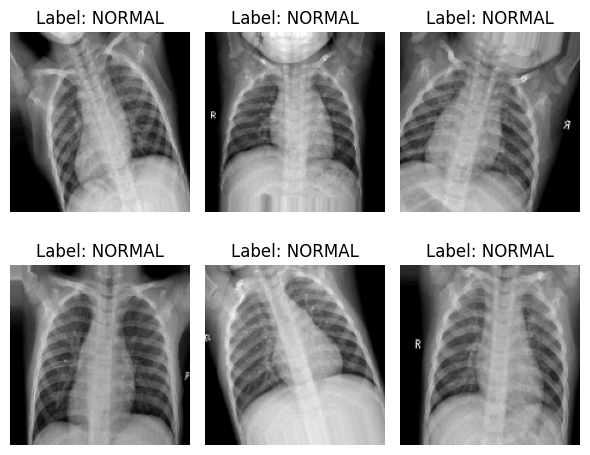

In [8]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the first 6 augmented images
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Label: " + ("PNEUMONIA" if labels[i] == 1 else "NORMAL"))
    plt.axis("off")
plt.tight_layout()
plt.show()


# 🧠 Phase 3: Modeling


## Model 1: CNN (Simple CNN)


### 1. Build Simple CNN Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the CNN
cnn_model = Sequential()

# Add the first convolutional layer
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))

# Add max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolutional layer
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 3D output to 1D vector
cnn_model.add(Flatten())

# Add a fully connected (dense) layer
cnn_model.add(Dense(units=256, activation='relu'))

# Output layer with 1 unit (for binary classification)
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

cnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,253,569 (81.08 MB)

 Trainable params: 21,253,569 (81.08 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Train the Model


In [10]:
history_cnn = cnn_model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=8)


Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745108313.863583      68 service.cc:145] XLA service 0x7a53a00037a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745108313.863670      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/195 ━━━━━━━━━━━━━━━━━━━━ 23:59 7s/step - accuracy: 0.4688 - loss: 0.6977

I0000 00:00:1745108316.735734      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 549ms/step - accuracy: 0.6744 - loss: 0.9753 - val_accuracy: 0.8616 - val_loss: 0.3117
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 538ms/step - accuracy: 0.8922 - loss: 0.2768 - val_accuracy: 0.8751 - val_loss: 0.3051
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 534ms/step - accuracy: 0.9050 - loss: 0.2436 - val_accuracy: 0.9163 - val_loss: 0.2213
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 535ms/step - accuracy: 0.9069 - loss: 0.2366 - val_accuracy: 0.9311 - val_loss: 0.1824
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 536ms/step - accuracy: 0.9267 - loss: 0.2095 - val_accuracy: 0.9176 - val_loss: 0.1971
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 535ms/step - accuracy: 0.9287 - loss: 0.1832 - val_accuracy: 0.9369 - val_loss: 0.1584
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 531ms/step - accuracy: 0.9334 - loss: 0.1772 - val_accuracy: 0.9356 - val_loss: 0.1652
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 550ms/step - accuracy: 0.9282 - loss: 0.1863 - va

## Model 2: MobileNetV2

### 1. Load & Build Model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Load the MobileNetV2 pre-trained model (without the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for your problem
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)  

# Create the final model
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()


/tmp/ipykernel_23/145411997.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### 2. Train the Model

In [12]:
history_mobilenet = mobilenet_model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=8)

Epoch 1/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 125s 577ms/step - accuracy: 0.8969 - loss: 0.2934 - val_accuracy: 0.9440 - val_loss: 0.1484
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 541ms/step - accuracy: 0.9435 - loss: 0.1710 - val_accuracy: 0.9575 - val_loss: 0.1031
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 537ms/step - accuracy: 0.9427 - loss: 0.1525 - val_accuracy: 0.9614 - val_loss: 0.1078
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 535ms/step - accuracy: 0.9461 - loss: 0.1431 - val_accuracy: 0.9588 - val_loss: 0.1172
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 538ms/step - accuracy: 0.9420 - loss: 0.1488 - val_accuracy: 0.9594 - val_loss: 0.1052
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 530ms/step - accuracy: 0.9466 - loss: 0.1356 - val_accuracy: 0.9665 - val_loss: 0.0904
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 549ms/step - accuracy: 0.9572 - loss: 0.1184 - val_accuracy: 0.9684 - val_loss: 0.0918
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 536ms/step - accuracy: 0.9485 - loss: 0

## Model 3: DenseNet121


### 1. Load & Build Model

In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load pre-trained base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze base

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model_densenet = Model(inputs=base_model.input, outputs=output)

# Compile
model_densenet.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### 2. Train the Model

In [14]:
history_densenet = model_densenet.fit(train_generator,
                                      validation_data=val_generator,
                                      epochs=8)

Epoch 1/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 157s 670ms/step - accuracy: 0.9005 - loss: 0.2658 - val_accuracy: 0.9350 - val_loss: 0.1813
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 542ms/step - accuracy: 0.9435 - loss: 0.1519 - val_accuracy: 0.9536 - val_loss: 0.1198
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 543ms/step - accuracy: 0.9443 - loss: 0.1418 - val_accuracy: 0.9517 - val_loss: 0.1220
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 111s 551ms/step - accuracy: 0.9482 - loss: 0.1366 - val_accuracy: 0.9627 - val_loss: 0.1010
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 544ms/step - accuracy: 0.9601 - loss: 0.1146 - val_accuracy: 0.9594 - val_loss: 0.1120
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 111s 551ms/step - accuracy: 0.9529 - loss: 0.1174 - val_accuracy: 0.9697 - val_loss: 0.0897
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 110s 546ms/step - accuracy: 0.9624 - loss: 0.1072 - val_accuracy: 0.9594 - val_loss: 0.1005
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 542ms/step - accuracy: 0.9572 - loss: 0

# 🧪 Phase 4: Evaluation, Comparison & Model Saving

## 1. Evaluate Individual Models


* ### Evaluate Simple CNN

In [15]:
cnn_loss, cnn_acc = cnn_model.evaluate(val_generator)
print(f"CNN Validation Accuracy: {cnn_acc:.4f} | Loss: {cnn_loss:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.9482 - loss: 0.1491
CNN Validation Accuracy: 0.9504 | Loss: 0.1453


* ### Evaluate MobileNetV2

In [16]:
mobilenet_loss, mobilenet_acc = mobilenet_model.evaluate(val_generator)
print(f"MobileNetV2 Validation Accuracy: {mobilenet_acc:.4f} | Loss: {mobilenet_loss:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 435ms/step - accuracy: 0.9671 - loss: 0.0826
MobileNetV2 Validation Accuracy: 0.9697 | Loss: 0.0838


* ### Evaluate DenseNet121

In [17]:
densenet_loss, densenet_acc = model_densenet.evaluate(val_generator)
print(f"DenseNet121 Validation Accuracy: {densenet_acc:.4f} | Loss: {densenet_loss:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.9629 - loss: 0.1071
DenseNet121 Validation Accuracy: 0.9627 | Loss: 0.1048


## 2. Visualize Confusion Matrices

### Generate Predictions and True Labels

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions and true labels for each model

# CNN Model
y_pred_cnn = (cnn_model.predict(val_generator) > 0.5).astype("int32")
y_true_cnn = val_generator.classes

# MobileNetV2 Model
y_pred_mobilenet = (mobilenet_model.predict(val_generator) > 0.5).astype("int32")
y_true_mobilenet = val_generator.classes

# DenseNet121 Model
y_pred_densenet = (model_densenet.predict(val_generator) > 0.5).astype("int32")
y_true_densenet = val_generator.classes


49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 581ms/step


### Plot Confusion Matrix

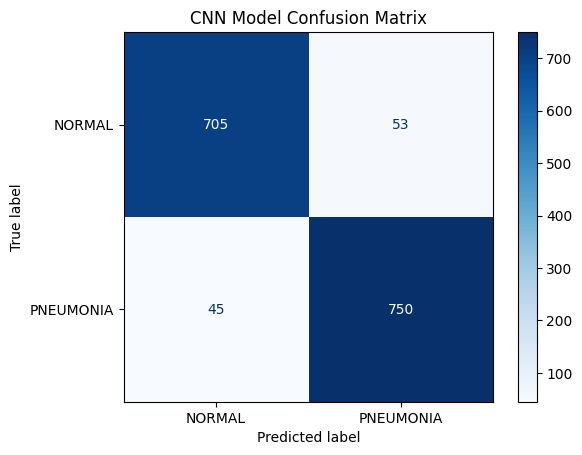

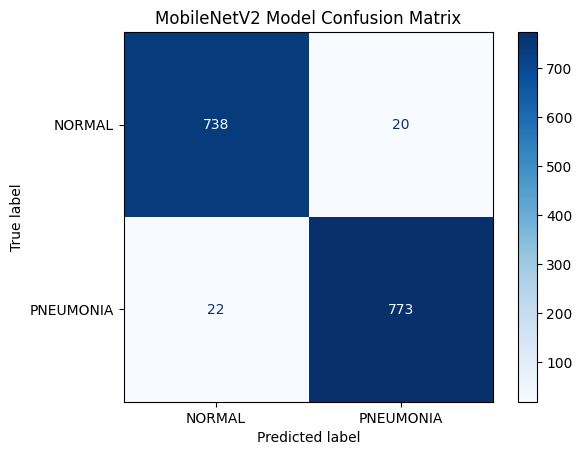

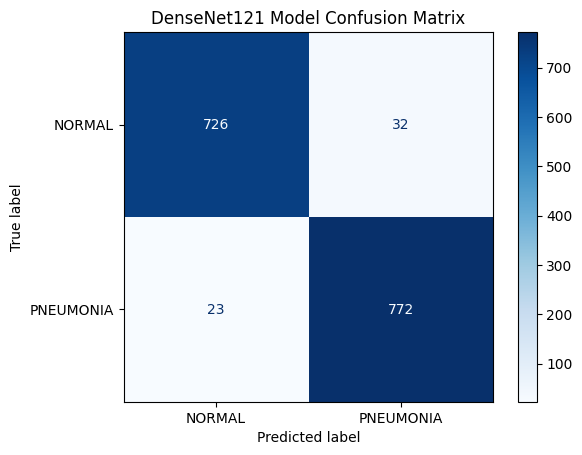

In [19]:
import matplotlib.pyplot as plt

# Plot Confusion Matrix for CNN Model
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=["NORMAL", "PNEUMONIA"])
disp_cnn.plot(cmap="Blues")
plt.title("CNN Model Confusion Matrix")
plt.show()

# Plot Confusion Matrix for MobileNetV2 Model
cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)
disp_mobilenet = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet, display_labels=["NORMAL", "PNEUMONIA"])
disp_mobilenet.plot(cmap="Blues")
plt.title("MobileNetV2 Model Confusion Matrix")
plt.show()

# Plot Confusion Matrix for DenseNet121 Model
cm_densenet = confusion_matrix(y_true_densenet, y_pred_densenet)
disp_densenet = ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=["NORMAL", "PNEUMONIA"])
disp_densenet.plot(cmap="Blues")
plt.title("DenseNet121 Model Confusion Matrix")
plt.show()

## 3. Classification Report

In [20]:
from sklearn.metrics import classification_report

# CNN Model Classification Report
print("🔍 CNN Model Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=["NORMAL", "PNEUMONIA"]))
print("=" * 60)

# MobileNetV2 Model Classification Report
print("🔍 MobileNetV2 Model Classification Report:")
print(classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=["NORMAL", "PNEUMONIA"]))
print("=" * 60)

# DenseNet121 Model Classification Report
print("🔍 DenseNet121 Model Classification Report:")
print(classification_report(y_true_densenet, y_pred_densenet, target_names=["NORMAL", "PNEUMONIA"]))
print("=" * 60)


🔍 CNN Model Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.93      0.94       758
   PNEUMONIA       0.93      0.94      0.94       795

    accuracy                           0.94      1553
   macro avg       0.94      0.94      0.94      1553
weighted avg       0.94      0.94      0.94      1553

🔍 MobileNetV2 Model Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.97      0.97       758
   PNEUMONIA       0.97      0.97      0.97       795

    accuracy                           0.97      1553
   macro avg       0.97      0.97      0.97      1553
weighted avg       0.97      0.97      0.97      1553

🔍 DenseNet121 Model Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.96      0.96       758
   PNEUMONIA       0.96      0.97      0.97       795

    accuracy                           0.96      1553
   macr

## 4. Compare Models

In [21]:
# Extract final metrics from each history
cnn_train_acc = history_cnn.history['accuracy'][-1]
cnn_val_acc = history_cnn.history['val_accuracy'][-1]
cnn_train_loss = history_cnn.history['loss'][-1]
cnn_val_loss = history_cnn.history['val_loss'][-1]

mobilenet_train_acc = history_mobilenet.history['accuracy'][-1]
mobilenet_val_acc = history_mobilenet.history['val_accuracy'][-1]
mobilenet_train_loss = history_mobilenet.history['loss'][-1]
mobilenet_val_loss = history_mobilenet.history['val_loss'][-1]

densenet_train_acc = history_densenet.history['accuracy'][-1]
densenet_val_acc = history_densenet.history['val_accuracy'][-1]
densenet_train_loss = history_densenet.history['loss'][-1]
densenet_val_loss = history_densenet.history['val_loss'][-1]

# Prepare the table
comparison_data = {
    "Model": ["CNN", "MobileNetV2", "DenseNet121"],
    "Train Accuracy": [cnn_train_acc, mobilenet_train_acc, densenet_train_acc],
    "Val Accuracy": [cnn_val_acc, mobilenet_val_acc, densenet_val_acc],
    "Train Loss": [cnn_train_loss, mobilenet_train_loss, densenet_train_loss],
    "Val Loss": [cnn_val_loss, mobilenet_val_loss, densenet_val_loss]
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,CNN,0.931595,0.942692,0.182043,0.148953
1,MobileNetV2,0.949300,0.969736,0.132030,0.079316
2,DenseNet121,0.956543,0.965873,0.113419,0.098665


## 5. Save Trained Models & LabelEncoder

* ### Save Models

In [22]:
cnn_model.save("models/cnn_model.h5")
mobilenet_model.save("models/mobilenetv2_model.h5")
model_densenet.save("models/densenet121_model.h5")

### Save LabelEncoder

In [23]:
import pickle

# Get the class indices from the training generator
class_indices = train_generator.class_indices

# Create an empty list to hold class labels in the correct order
class_labels = [None] * len(class_indices)

# Fill the list with class names based on their index
for label, index in class_indices.items():
    class_labels[index] = label

# Save the class labels to a file using pickle
with open("models/class_labels.pkl", "wb") as f:
    pickle.dump(class_labels, f)


## 6. Build Predict Function for Inference

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(model, image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print(f"Prediction: PNEUMONIA ({prediction:.2f})")
    else:
        print(f"Prediction: NORMAL ({1 - prediction:.2f})")


# 📊 Phase 5: Final Generalization Testing on Holdout Set

In [25]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os


## 1️⃣ Load and Preprocess Test Set

In [26]:
# Define path to test data and images
test_csv_path = "/kaggle/working/processed_data/test_labels.csv"
test_image_dir = "/kaggle/working/processed_data/test"

# Load test dataframe
test_df = pd.read_csv(test_csv_path)

# Preprocessing: Normalization, resizing, etc. (same as training)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator (no shuffle for evaluation)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 validated image filenames belonging to 2 classes.


## 2️⃣ Load and Evaluate All Models

In [27]:
# Load all trained models
cnn_model = load_model("models/cnn_model.h5")
mobilenet_model = load_model("models/mobilenetv2_model.h5")
densenet_model = load_model("models/densenet121_model.h5")

# Evaluate each model
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
mobilenet_loss, mobilenet_acc = mobilenet_model.evaluate(test_generator)
densenet_loss, densenet_acc = densenet_model.evaluate(test_generator)

# Print results
print(f"CNN Model - Accuracy: {cnn_acc:.4f}, Loss: {cnn_loss:.4f}")
print(f"MobileNetV2 Model - Accuracy: {mobilenet_acc:.4f}, Loss: {mobilenet_loss:.4f}")
print(f"DenseNet121 Model - Accuracy: {densenet_acc:.4f}, Loss: {densenet_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.7151 - loss: 0.6853
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.8429 - loss: 0.4968
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.8106 - loss: 0.6480
CNN Model - Accuracy: 0.8269, Loss: 0.4119
MobileNetV2 Model - Accuracy: 0.8894, Loss: 0.3204
DenseNet121 Model - Accuracy: 0.8798, Loss: 0.3915


## 3️⃣ Generate Predictions & Classification Reports

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step
📘 CNN Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.59      0.72       234
   PNEUMONIA       0.80      0.97      0.87       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



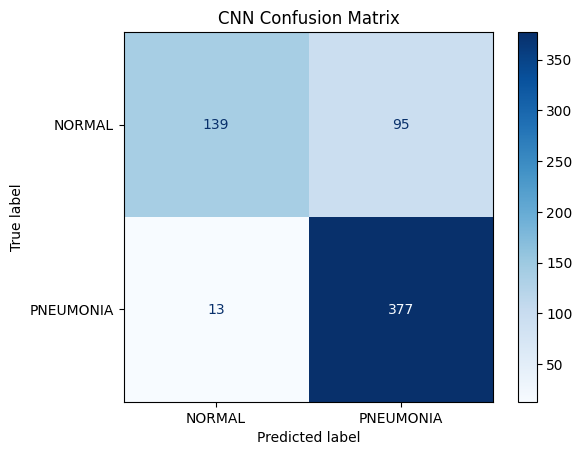

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step
📗 MobileNetV2 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.77      0.84       234
   PNEUMONIA       0.87      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



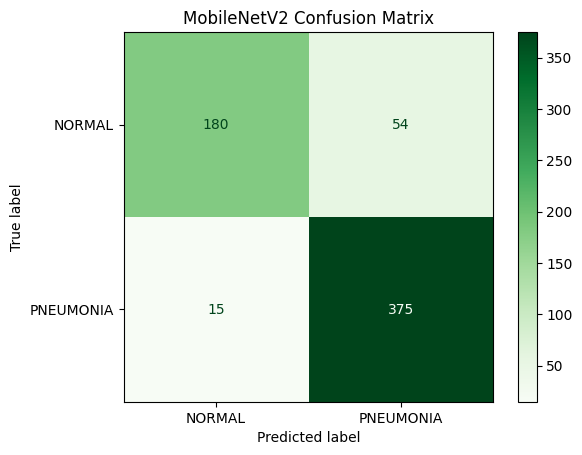

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step
📙 DenseNet121 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.75      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.87       624
weighted avg       0.88      0.88      0.88       624



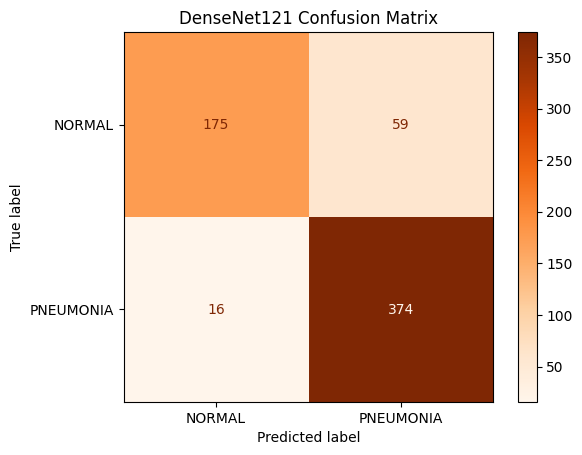

In [28]:
# Get true labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# CNN Model Predictions
y_pred_cnn = (cnn_model.predict(test_generator) > 0.5).astype("int32")
print("📘 CNN Classification Report:")
print(classification_report(y_true, y_pred_cnn, target_names=class_labels))
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_labels).plot(cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.show()

# MobileNetV2 Predictions
y_pred_mobilenet = (mobilenet_model.predict(test_generator) > 0.5).astype("int32")
print("📗 MobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred_mobilenet, target_names=class_labels))
cm_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)
ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet, display_labels=class_labels).plot(cmap="Greens")
plt.title("MobileNetV2 Confusion Matrix")
plt.show()

# DenseNet121 Predictions
y_pred_densenet = (densenet_model.predict(test_generator) > 0.5).astype("int32")
print("📙 DenseNet121 Classification Report:")
print(classification_report(y_true, y_pred_densenet, target_names=class_labels))
cm_densenet = confusion_matrix(y_true, y_pred_densenet)
ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=class_labels).plot(cmap="Oranges")
plt.title("DenseNet121 Confusion Matrix")
plt.show()


## 4️⃣ Visualize Sample Predictions 

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step


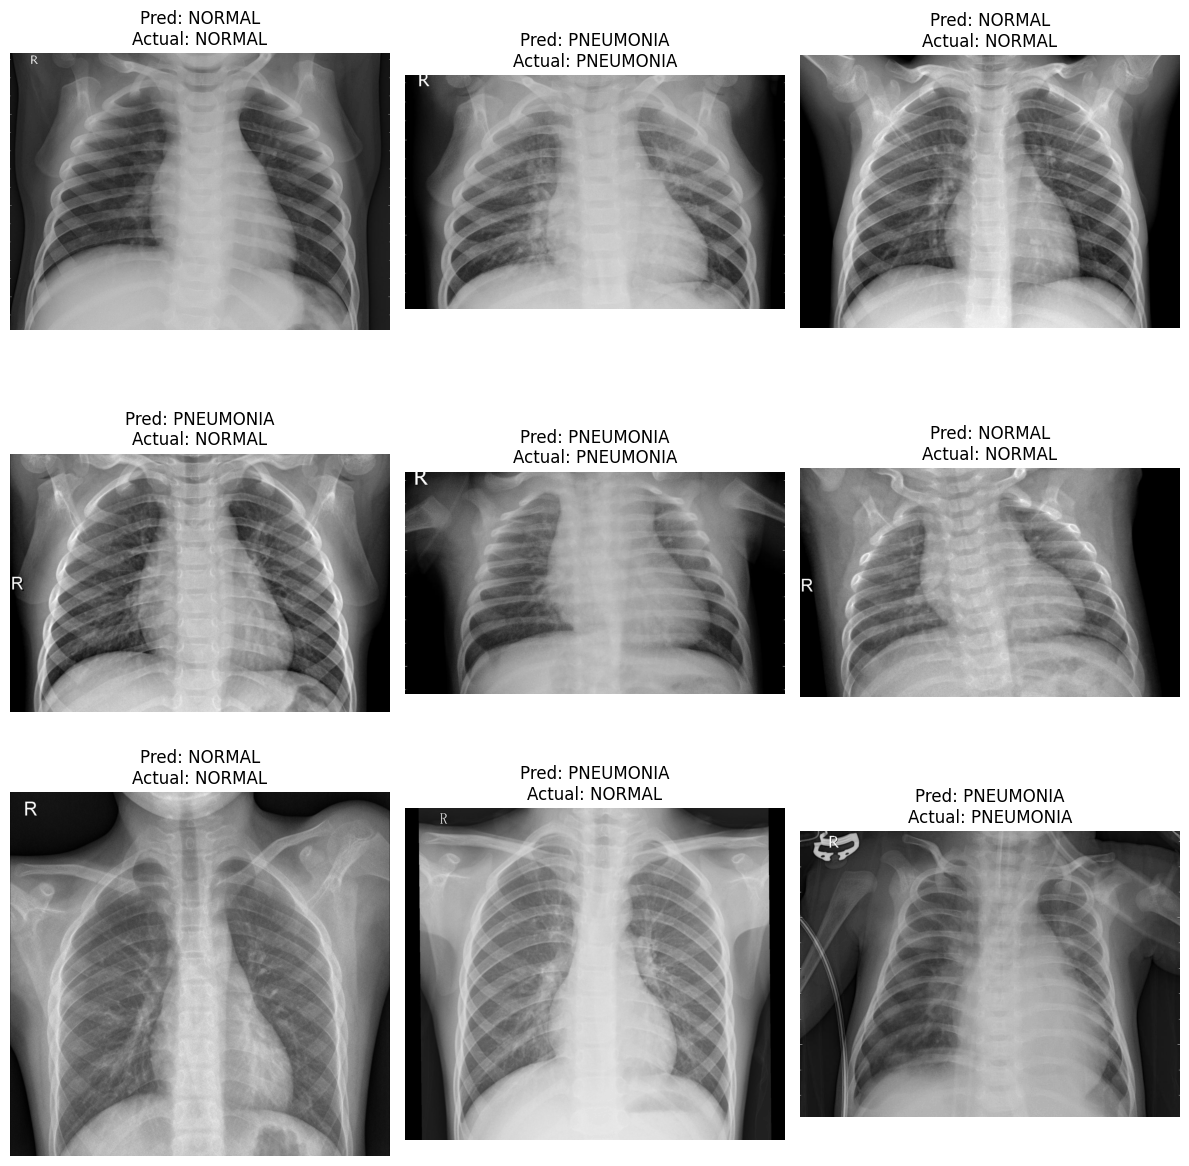

In [29]:
# Display sample predictions from test set
import random

# Get filenames
filenames = test_generator.filenames
sample_indices = random.sample(range(len(filenames)), 9)

# Predict using one model (e.g., DenseNet)
sample_preds = (densenet_model.predict(test_generator) > 0.5).astype("int32")

# Plot sample images with predicted vs actual labels
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    img_path = os.path.join(test_image_dir, filenames[idx])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    pred_label = class_labels[sample_preds[idx][0]]
    true_label = class_labels[y_true[idx]]
    plt.title(f"Pred: {pred_label}\nActual: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# 📋 Summary of the Code 

This notebook aims to build and evaluate a binary classification model for detecting **Pneumonia** from chest X-ray images. The workflow consists of multiple phases:

### 1. **Data Collection & Organization** 🗂️
   - Explore and understand the original dataset.
   - Merge and organize the images into a unified folder structure.
   - Generate metadata in CSV format for efficient data handling.

### 2. **Data Preprocessing** 🔧
   - Load the CSV files containing metadata.
   - Balance the classes in the training set to handle class imbalances.
   - Apply **Data Augmentation & Image Generators** for real-time image augmentation during training.
   - Visualize augmented samples to understand how transformations are applied to the images.

### 3. **Modeling** 🧠
   - **Model 1**: Custom CNN (Convolutional Neural Network) built from scratch.
   - **Model 2**: MobileNetV2 (Transfer Learning).
   - **Model 3**: DenseNet121 (Transfer Learning).

### 4. **Evaluation, Comparison & Model Saving** 📊
   - Evaluate each model's performance on validation data using accuracy and loss metrics.
   - Visualize confusion matrices for each model to assess true/false positives and negatives.
   - Generate classification reports (precision, recall, F1-score) for deeper insights.
   - Compare the models based on their evaluation metrics.
   - Save the trained models and class label encoder for future inference.

### 5. **Final Testing on Holdout Set** ✅
   - Load and preprocess the test set (unseen data).
   - Evaluate all trained models on the test set to estimate their generalization performance.
   - Generate predictions and display classification reports for each model.
   - (Optional) Visualize sample predictions to compare predicted vs actual labels.

---

The notebook concludes by saving the best-performing model for future use and demonstrating the model’s ability to generalize on unseen data.
